# Build Anomaly Detection / Fraud Detection Model from the Withdrawal Banking data


In this notebook, I will detect outliers using the unsupervised learning algorithm: [Isolation Forest](https://en.wikipedia.org/wiki/Isolation_forest).

### Why Isolation Forest?

Clustering is a top technqiue applied to unsupervised learning problems. 

According to [Wikipedia](https://en.wikipedia.org/wiki/Isolation_forest):

```
The Isolation Forest (iForest) algorithm took advantage of the attributes of anomalies being “few and different”, they are easier to “isolate” compared to normal points. So instead of trying to build a model of normal instances, it explicitly isolates anomalous points in the dataset.

The main advantage of this approach is the possibility of exploiting sampling techniques to an extent that is not allowed in the profile-based methods, creating a very fast algorithm with a low memory demand
```

With iForest, don’t need to scale the variables before applying the technique, unlike most other clustering techniques.

I use the `Py`thon `O`utlier `D`etection Python Library: [PyOD](https://pyod.readthedocs.io/en/latest/index.html),
a comprehensive but easy-to-use Python library for detecting anomalies in multivariate data. Whether you are working with a small-scale project or large datasets, PyOD provides a range of algorithms to suit your needs.

## Import Modules

In [26]:
import math
import os
from typing import List

from dotenv import load_dotenv
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib
plt.style.use("ggplot")
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (12,8)

import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.ensemble import IsolationForest

pd.options.mode.chained_assignment = None

## Get the Bank Model Data Sets

In [27]:
load_dotenv()

True

In [28]:
# Get Path from environment variable
PROCESSED_DATA_PATH = os.environ.get("PROCESSED_DATA_PATH")

df_withdrawals = pd.read_csv(PROCESSED_DATA_PATH) #The withdrawl transactions

In [29]:
df_withdrawals.head()

,account_id,type,amount,sum_5days,count_5days
0,1,WITHDRAWAL,200.0,200.0,1.0
1,1,WITHDRAWAL,5300.0,5300.0,1.0
2,1,WITHDRAWAL,7500.0,7500.0,1.0
3,1,WITHDRAWAL,14.6,14.6,1.0
4,1,WITHDRAWAL,2452.0,2452.0,1.0


---

# Creating the Anomaly Detection Model

In [30]:
# How much of the data to consider as outliers here I set to 0.1%
# Need to be careful not to set the percentage too high otherwise you over alert.
anomaly_proportion = 0.001

In [31]:
# training the IForest detector

# clf_name = "Anomaly Detection - Isolation Forest"
# clf = IForest(contamination=anomaly_proportion, random_state=42) 
model_IF = IsolationForest(contamination=anomaly_proportion, random_state=42)

In [32]:
#Train the models using FIT
X = df_withdrawals[["count_5days", "sum_5days"]]
model_IF.fit(X)

,n_estimators,100
,max_samples,'auto'
,contamination,0.001
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


In [33]:
# Get the prediction labels (i.e, the predictions) and outlier scores for the training data
df_withdrawals["y_pred"] = model_IF.predict(X) # binary labels (0:inlier - good data, 1: outliers - anomaly)
df_withdrawals["y_scores"] = model_IF.decision_function(X) # raw outlier scores. Bigger numbers mean the larger the anomaly

In [34]:
df_withdrawals.loc[:, ["count_5days", "sum_5days", "y_scores", "y_pred"]]

,count_5days,sum_5days,y_scores,y_pred
0,1.0,200.0,0.330174,1
1,1.0,5300.0,0.343121,1
2,1.0,7500.0,0.319748,1
3,1.0,14.6,0.412298,1
4,1.0,2452.0,0.367744,1
...,...,...,...,...
634566,1.0,14.6,0.412298,1
634567,2.0,18914.6,0.248740,1
634568,1.0,14.6,0.412298,1
634569,2.0,25614.6,0.188544,1


---

# To Visualize Model Results



#### Plot A Scatter Plot with Inlier and Outlier Details


In [35]:
#Create function to plot out data Scatter plot of the data 

def outlier_plot(
    data: pd.DataFrame, 
    outlier_method_name: str, 
    x_var: str, 
    y_var: str, 
    xaxis_limits: List[int | float] =[0,1], 
    yaxis_limits: List[int | float] =[0,1]
) -> sns.FacetGrid:
    """
    Creates a Seaborn FacetGrid scatter plot figure of Anomalies .

    Args:
        data (pd.DataFrame): The DataFrame to plot.
        outlier_method_name (str): The name of the classifier technique - IForest in this case
        y_var (str): The column to use for faceting across columns.
        x_var (str): The column to use for faceting across rows.
        xaxis_limits (List[int | float]): The limits of the x-axis
        yaxis_limits (List[int | float]): The limits of the y-axis

    Returns:
        sns.FacetGrid: The generated Seaborn FacetGrid object.
    """
    print(f'Outlier Method: {outlier_method_name}')
    
    method = f'{outlier_method_name}_anomaly'
    
    print(f"Number of anomalous values {len(data[data["y_pred"]== -1])}")
    print(f"Number of non anomalous values  {len(data[data["y_pred"]== 1])}")
    print(f'Total Number of Values: {len(data)}')
    
    g = sns.FacetGrid(data, col="y_pred", height=4, hue="y_pred", hue_order=[1,-1])
    g.map(sns.scatterplot, x_var, y_var)
    g.fig.suptitle(f'Outlier Method: {outlier_method_name}', y=1.10, fontweight='bold')
    g.set(xlim=xaxis_limits, ylim=yaxis_limits)
    axes = g.axes.flatten()
    axes[0].set_title(f"Outliers (Anomalies) \n{len(data[data["y_pred"]== -1])} points")
    axes[1].set_title(f"Inliers (Good Values)\n {len(data[data["y_pred"]==  1])} points")
    return g

Outlier Method: Isolation Forest
Number of anomalous values 633
Number of non anomalous values  633938
Total Number of Values: 634571


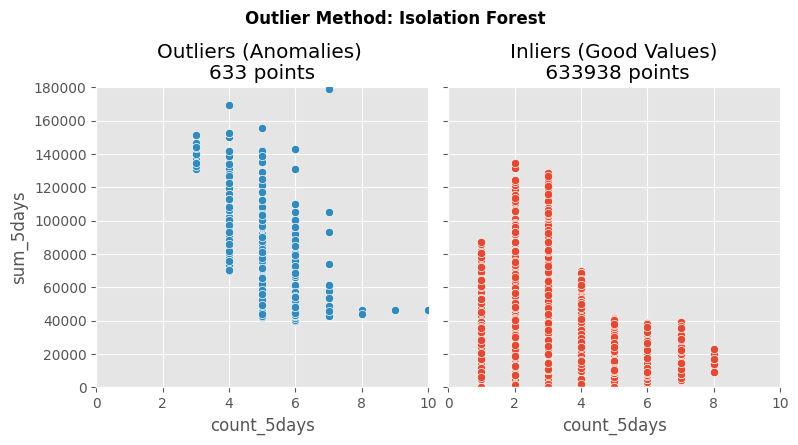

In [36]:
outlier_plot(df_withdrawals, "Isolation Forest", "count_5days", "sum_5days", [0, 10], [0, 180000]);


### Result Discussion
Red Dots (normal transactions) consist of 99.9% of all withdrawal transactions. This matches our setting of the proportion of anomalies to detect of 0.1%. We see that approximately 99.9% of all withdrawal transactions were good. While, approximately less than 1% of withdrawl transactions were anomalies. 

$$Anomalies\% = (\frac{633}{634571}) * 100 = 0.09975243$$

$$NonAnomalies\% = (\frac{633938}{634571}) * 100 = 99.9$$


---
---
# Next Steps: Using Results for Anti-Money Laundering (AML) or Fraud Analytics


* Review the Withdrawl Anomalies
    * Pay particular attention to accounts that single transactions with over $80K
    * Pay particular attention to accounts with over $65K accumlations with more than 4 withdrawl transaction within the past 5 days
    * Pay particular attention to accounts with over $45k accumulations with more than 5 withrawls within the past 5 days
